In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt

from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN, KMeans, AffinityPropagation
import seaborn as sns
import tardis

In [2]:
df = pd.read_csv('cluster_loci_1.csv',  header=0, index_col=False)

In [3]:
coords = df.sort_values(['worker_contact_latitude','worker_contact_longitude'],ascending=True).groupby(['primary_market_id', 'position_id', 'worker_id']).sum()

In [4]:
wh = tardis.get_wh_postgres_connection()
gc=tardis.get_google_sheets_connection()

In [5]:
shift_df = wh.execute_query(
"""
SELECT
    worker_id,
    shift_id,
    venue_id,
    venue_latitude,
    venue_longitude,
    is_reconciled_needed_primary, 
    is_reconciled_needed_worked,
    COALESCE(venue_closest_market_id, venue_listed_market_id, company_market_id) as market_id
FROM starbase_dev.shift_base
LEFT JOIN starbase_dev.group_base USING(group_id)
LEFT JOIN starbase_dev.event_base USING(event_id)
LEFT JOIN starbase_dev.venue_base USING(venue_id)
LEFT JOIN starbase_dev.shift_kpi_flags USING(shift_id)
LEFT JOIN starbase_dev.company_base USING(company_id)
WHERE is_reconciled_needed_primary OR is_reconciled_needed_worked
"""
)

In [6]:
shift_df.to_pickle('shift_df_raw.pkl')

In [4]:
shift_base = pd.read_pickle('shift_df_raw.pkl')

In [5]:
shift_base.is_reconciled_needed_worked[shift_base.is_reconciled_needed_worked == 0].count()

165935

In [6]:
shift_base.is_reconciled_needed_worked.value_counts()

True     606283
False    165935
Name: is_reconciled_needed_worked, dtype: int64

In [7]:
shift_base = shift_base.groupby('venue_id')

In [8]:
num_shifts_in_venue = shift_base.size().rename('num_shifts_in_venue')

In [9]:
shift_base_4 = shift_base.venue_latitude.first()

In [10]:
shift_base_5 = shift_base.venue_longitude.first()

In [11]:
shift_base_7 = shift_base.market_id.first()

In [12]:
shift_base_1 = shift_base.is_reconciled_needed_primary.sum()

In [13]:
shift_base_2 = shift_base.is_reconciled_needed_worked.sum()

In [14]:
shift_base_3 = pd.concat([shift_base_1,shift_base_2], axis=1)

In [15]:
shift_base_3['is_reconciled_needed_primary'] = shift_base_3.is_reconciled_needed_primary.clip(lower=1)

In [16]:
shift_base_3['success_rate']=shift_base_3.is_reconciled_needed_worked/shift_base_3.is_reconciled_needed_primary

In [17]:
shift_base_3.isna().mean()

is_reconciled_needed_primary    0.0
is_reconciled_needed_worked     0.0
success_rate                    0.0
dtype: float64

In [18]:
shift_base_6 = pd.concat([shift_base_3, shift_base_4, shift_base_5, shift_base_7, num_shifts_in_venue], axis=1)

In [19]:
shift_base_6.isna().mean()

is_reconciled_needed_primary    0.000000
is_reconciled_needed_worked     0.000000
success_rate                    0.000000
venue_latitude                  0.005854
venue_longitude                 0.005854
market_id                       0.000000
num_shifts_in_venue             0.000000
dtype: float64

In [20]:
shift_base_final = shift_base_6[shift_base_6.market_id==1].dropna(subset=['venue_latitude'])

In [21]:
def haversine(lonlat1, lonlat2):

    # convert decimal degrees to radians 
    lat1, lon1 = lonlat1
    lat2, lon2 = lonlat2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371
    return c * r

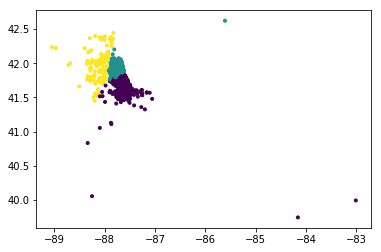

In [78]:
from scipy.cluster.vq import kmeans2, whiten
m = 1
p = 19
x, y = kmeans2(whiten(coords.loc[m].loc[p][['worker_contact_latitude', 'worker_contact_longitude']]), k=3, iter = 20)
plt.scatter(coords.loc[m].loc[p]['worker_contact_longitude'], coords.loc[m].loc[p]['worker_contact_latitude'], c=y, marker='.',)

# plt.scatter(coords.loc[:,'worker_contact_latitude'], coords.loc[:,'worker_contact_longitude'], c=y, alpha=0.33333);

In [23]:
np.ceil(coords.loc[m].loc[p].shape[0]/1000.0)
np.ceil(coords.loc[m].loc[p].shape[0]/500.0)

5.0

In [24]:
(distances.min(axis=1)>2).mean()

NameError: name 'distances' is not defined

In [25]:
from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.cluster.vq import kmeans2, whiten
import scipy as sp
m = 1
p = 19
r2 = list()
n_small_clusts = list()
is_training = np.random.choice([True, False], size= shift_base_final.shape[0], p=[0.5, 0.5])
clusts_pop = list(map(int, range(1,20,1)))
for k in range(1,20):
    # get landmarks
    x, y = kmeans2(coords.loc[m].loc[p][['worker_contact_longitude', 'worker_contact_latitude']], k=k, iter =1000)
    
    # get distance form venues to landmarks
    distances = sp.spatial.distance.cdist(shift_base_final[['venue_longitude', 'venue_latitude']], x, metric=haversine)
    
#   run linear regression
    lr = linear_model.LinearRegression()
    lr.fit(distances[is_training], shift_base_final.success_rate[is_training].values)
    y_pred = lr.predict(distances[is_training==False])
    rSquared = r2_score(shift_base_final.success_rate[is_training==False].values, y_pred)
    r2.append(rSquared)
    clust_size = pd.Series(y).value_counts()
    n_small_clusts.append((clust_size<=10).sum())
    
    
# testing overfitting


/Users/laavanyaganesh/repo/client_churn/venv/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Users/laavanyaganesh/repo/client_churn/venv/lib/python2.7/site-packages/scipy/cluster/vq.py:523: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


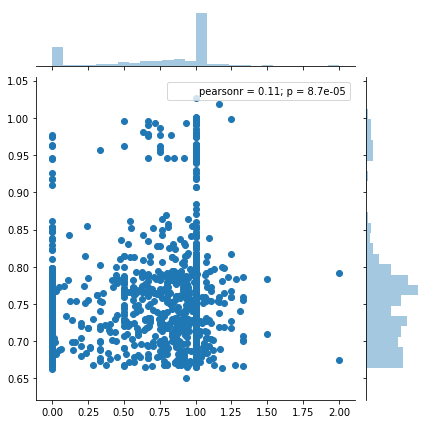

In [26]:
sns.jointplot(shift_base_final.success_rate[is_training==False].values, y_pred)

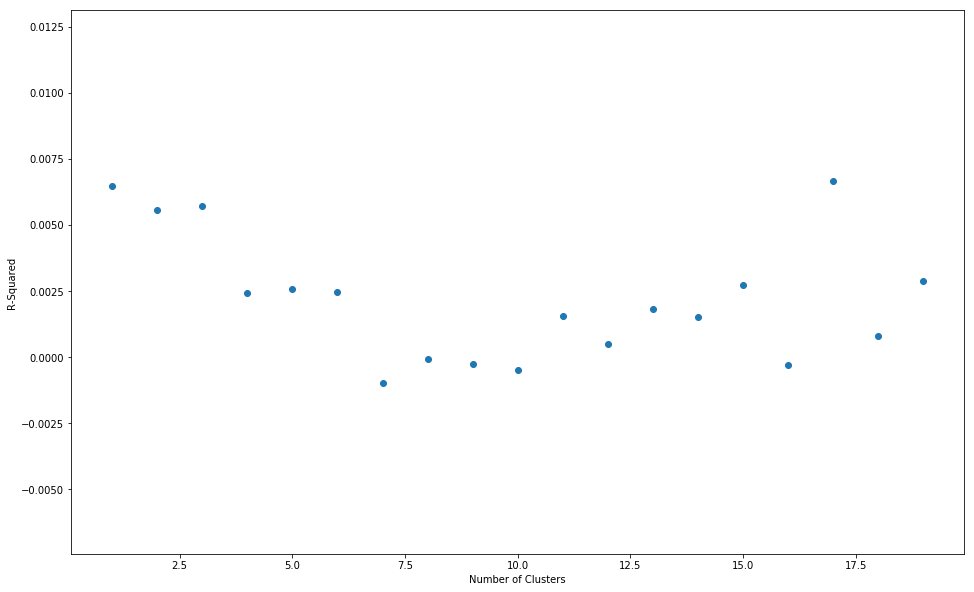

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
plt.scatter(clusts_pop, r2)
plt.xlabel('Number of Clusters')
plt.ylabel('R-Squared')
plt.show()

In [90]:
( distances[:, cluster_slice]**0.4 ==  distances_sliced).sum(axis=1)

array([1, 1, 1, ..., 1, 1, 1])

In [112]:
from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.cluster.vq import kmeans2, whiten, kmeans
import scipy as sp
m = 1
p = 19

is_training = np.random.choice([True, False], size= shift_base_final.shape[0], p=[0.5, 0.5])
clusts_pop = list(map(int, range(1,20,1)))

high_volume_venues = shift_base_final.num_shifts_in_venue > 20

r2_info = pd.DataFrame(index=range(1,20,1)) #( index is your number clusters)
r2_info['sum_r2'] = 0
r2_info['count_r2'] = 0
# PREINITIALIZE r2_info with two columns sum_r2 and count_r2 set to 0 


# Initialize retainers for best performing cluster
max_r2 = -np.Inf
# best_x = _____
# best_y = ______
r2_list = list()

# For each param value
for k in range(1,31):
    print(k)
    # For each randomization (100 randomizations)
    running_tot = 0
    for i in range(10):
        # get landmarks
        x, y = kmeans2(coords.loc[m].loc[p][['worker_contact_longitude', 'worker_contact_latitude']],  k=k, iter=500)
        is_training = np.random.choice([True, False], size= shift_base_final.shape[0], p=[0.5, 0.5])

        # assess clust size to remove small clusters
        clust_size = pd.Series(y).value_counts()
        clust_size = clust_size.reindex(range(len(x)))
        clust_size.fillna(0, inplace=True)
        clust_size.sort_index(inplace=True)

        # get distance form venues to landmarks
        distances = sp.spatial.distance.cdist(shift_base_final[['venue_longitude', 'venue_latitude']], x, metric=haversine)
        distances = np.clip(distances, 0, 50)

        # prepare slicing for distances columns
        cluster_slice = clust_size>20
        
        # prepare slicing for rows
        training_slice = is_training&high_volume_venues
        testing_slice = is_training==False&high_volume_venues
#         training_slice = high_volume_venues
#         testing_slice = high_volume_venues
        
        # remove small clusters (columns) (USING cluster_slice)
        distances_sliced = distances[:, cluster_slice]
        distances_sliced = np.expand_dims(distances_sliced.min(axis=1)**0.5, 1)
        distances_sliced = np.concatenate([distances_sliced, distances[:, cluster_slice]**0.5 == distances_sliced],
                                         axis=1)
        distances_sliced = distances_sliced[:, :-1]
        # build regression model
        lr = linear_model.LinearRegression()
        
        # train on training data (USE training_slice created above)
        lr.fit(distances_sliced[training_slice], shift_base_final.success_rate[training_slice].values)
        # predict for holdout slice (USE testing_slice)
        y_pred = lr.predict(distances_sliced[training_slice])
        r2 = r2_score(shift_base_final.success_rate[training_slice].values, y_pred)
        
        num_clusters = cluster_slice.sum()
        
        r2_info.loc[num_clusters,'sum_r2'] +=  r2
        r2_info.loc[num_clusters,'count_r2'] += 1
        
        running_tot+=r2
        
        
        # update r2_info adding r2 to sum_r2 and 1 to count r2 for the appropriate index
        
        
        # compare r2 to max_r2
        if r2 > max_r2:
            max_r2=r2
            best_x=x
            best_y=y
            if k==10:
                max_r2_10=r2
                best_x_10=x
                best_y_10=y

            # save best x, best y, and update max r2
    r2_list.append(running_tot/100)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


KeyError: u'the label [20] is not in the [index]'

In [29]:
from sklearn.linear_model import LogisticRegression

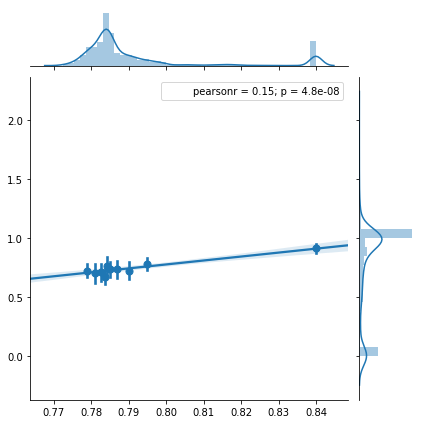

In [54]:
sns.jointplot(y_pred, shift_base_final.success_rate[testing_slice].values, kind='reg', x_bins=10)

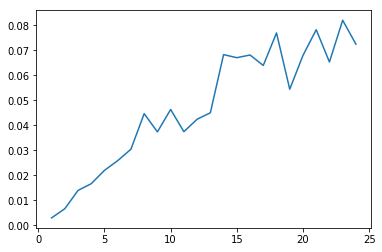

In [114]:
plt.plot(range(1,25),[x*10 for x in r2_list])

In [58]:
max_r2

0.009011884026990713

In [33]:
distances

array([[ 0.70013654, 10.33166953, 10.42950562, ...,  3.00722067,
        21.08211484, 50.        ],
       [ 6.73304441, 16.40381281,  4.36638592, ...,  3.43363745,
        15.01231607, 50.        ],
       [44.09986271, 50.        , 33.0339608 , ..., 40.60959902,
        22.38217604, 50.        ],
       ...,
       [ 2.65133164, 12.31925959,  8.43849258, ...,  1.3167748 ,
        19.09091717, 50.        ],
       [ 2.2375743 , 11.9020734 ,  8.85879377, ...,  1.63304696,
        19.51115389, 50.        ],
       [ 1.35202755, 11.00128865,  9.7637747 , ...,  2.41136534,
        20.41616268, 50.        ]])

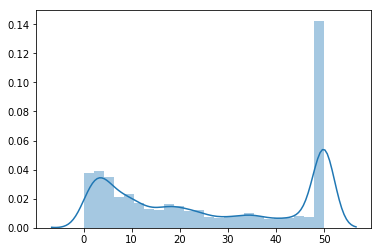

In [34]:
sns.distplot(distances.flatten())

In [35]:
sns.distplot(np.flatten(distances_sliced[training_slice]))

AttributeError: 'module' object has no attribute 'flatten'

In [36]:
r2_score(shift_base_final.success_rate[training_slice].values, lr.predict(distances_sliced[training_slice]))


0.0008679479459218209

In [37]:
max_r2

0.006627759707812597

In [38]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor

In [39]:
clust_size = pd.Series(best_y).value_counts()
clust_size = clust_size.reindex(range(len(best_x)))
clust_size.fillna(0, inplace=True)
clust_size.sort_index(inplace=True)

distances = sp.spatial.distance.cdist(shift_base_final[['venue_longitude', 'venue_latitude']], best_x, metric=haversine)
distances = np.clip(distances, 0, 50)

# prepare slicing for distances columns
cluster_slice = clust_size>20

# prepare slicing for rows
training_slice = is_training&high_volume_venues
testing_slice = is_training==False&high_volume_venues

# remove small clusters (columns) (USING cluster_slice)
distances_sliced = distances[:, cluster_slice]


# build regression model
model = RandomForestRegressor(max_depth=18)#GradientBoostingRegressor(n_estimators=1000, verbose=True, max_depth=3)

# train on training data (USE training_slice created above)
model.fit(distances_sliced[training_slice], shift_base_final.success_rate[training_slice].values)
# predict for holdout slice (USE testing_slice)
y_pred = model.predict(distances_sliced[testing_slice])
r2 = r2_score(shift_base_final.success_rate[testing_slice].values, y_pred)

In [40]:

r2

-0.16092879162722862

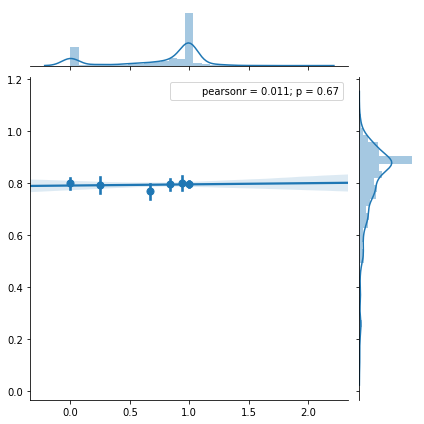

In [41]:
sns.jointplot(shift_base_final.success_rate[testing_slice].values, y_pred, kind='reg', x_bins=10)

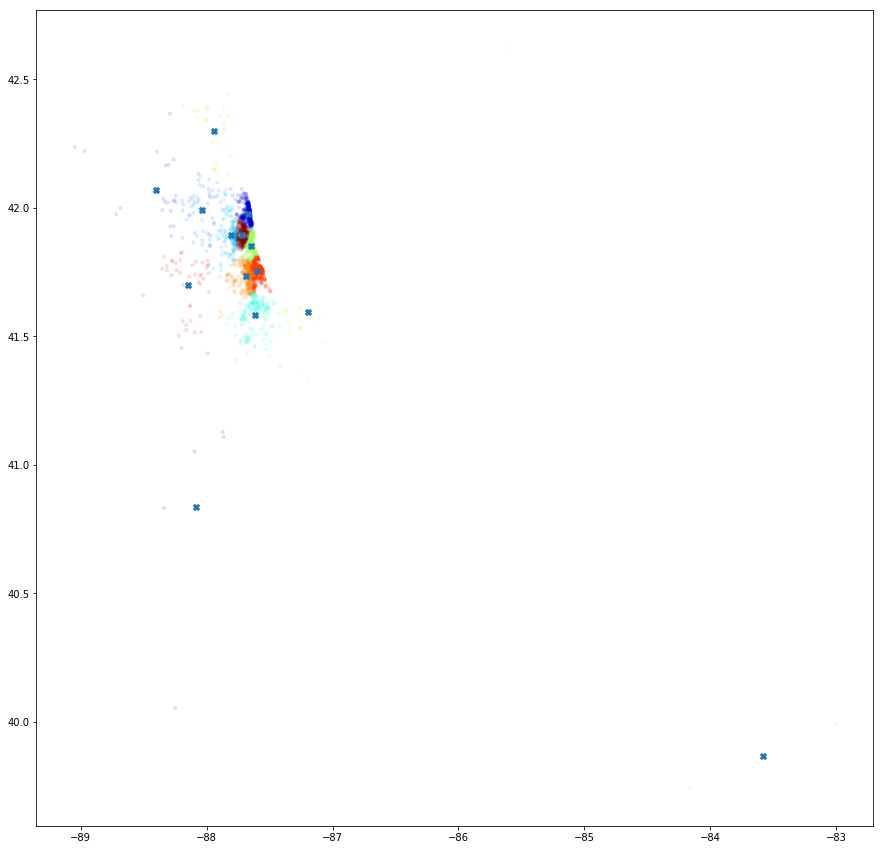

In [118]:
plt.figure(figsize=(15,15))
plt.scatter(coords.loc[m].loc[p]['worker_contact_longitude'], coords.loc[m].loc[p]['worker_contact_latitude'], c=best_y,marker='.', cmap='jet',alpha=0.1)
plt.scatter(best_x[:,0],best_x[:,1], marker='X')

In [60]:
r2

0.0015216846776627824

In [61]:
y_pred_All = model.predict(distances_sliced[high_volume_venues]**0.5)


ValueError: Number of features of the model must match the input. Model n_features is 7 and input n_features is 1 

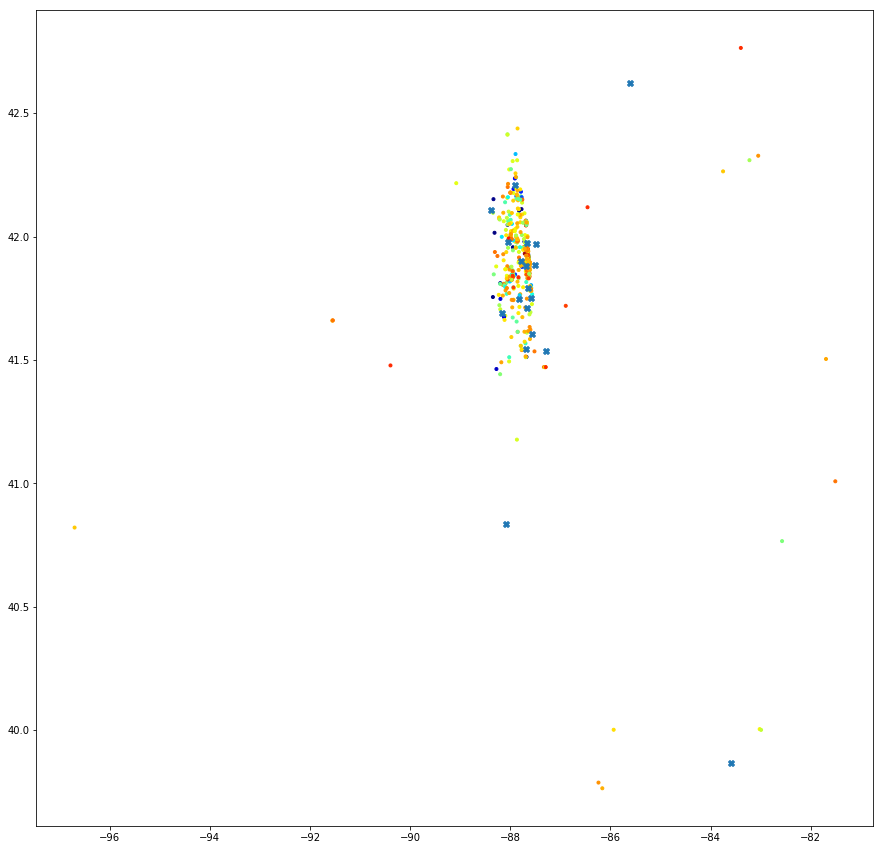

In [71]:
plt.figure(figsize=[15,15])
plt.scatter(shift_base_final['venue_longitude'][high_volume_venues], shift_base_final['venue_latitude'][high_volume_venues], c=shift_base_final.success_rate[high_volume_venues].values, marker='.',cmap='jet')
plt.scatter(best_x[:,0],best_x[:,1], marker='X')

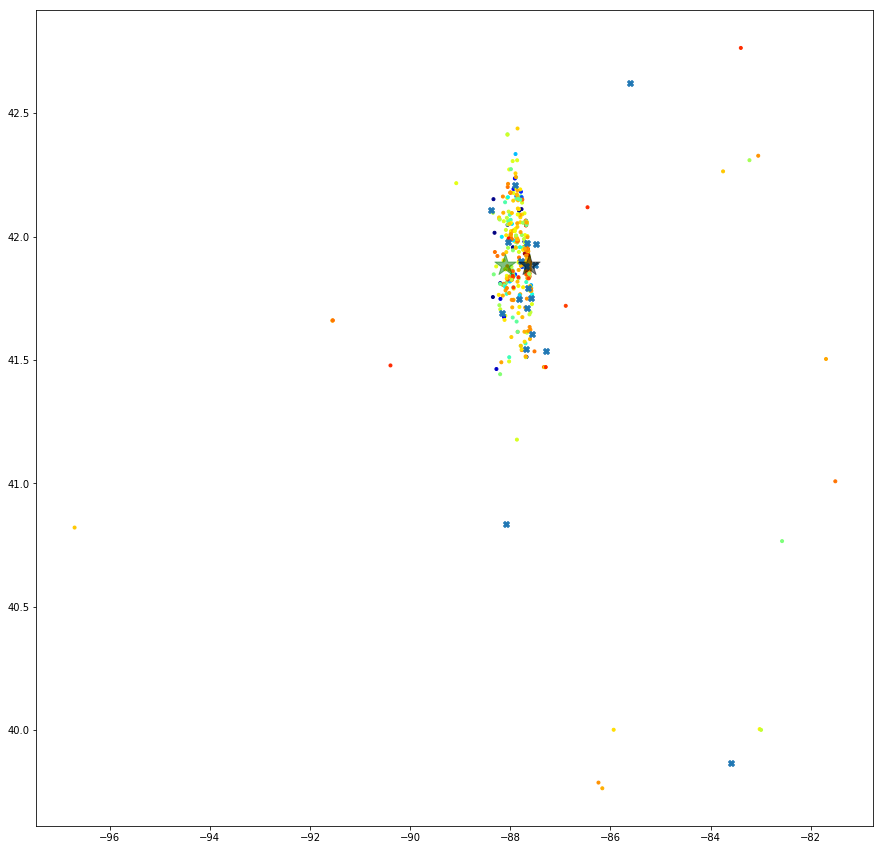

In [72]:
plt.figure(figsize=[15,15])
plt.scatter(shift_base_final['venue_longitude'][high_volume_venues], shift_base_final['venue_latitude'][high_volume_venues], c=shift_base_final.success_rate[high_volume_venues].values, marker='.',cmap='jet')
plt.scatter(best_x[:,0],best_x[:,1], marker='X')
plt.scatter([-87.627803], [41.884392], 500, 'k', alpha=0.5, marker='*')
plt.scatter([-88.105917],[41.883346], 500, 'g', alpha=0.5, marker='*')

In [73]:
r2_info

,sum_r2,count_r2
1,0.206794,102
2,0.013749,117
3,0.228050,129
4,0.347286,120
5,0.379461,123
6,0.319328,132
7,0.298037,126
8,0.294052,145
9,0.220740,128
10,0.297584,154


In [115]:
max_r2

0.1727517685527692

In [116]:
best_x

array([[-88.0838968 ,  40.835047  ],
       [-87.67409312,  41.97817078],
       [-88.40270838,  42.07016162],
       [-88.03446785,  41.99128367],
       [-87.80400672,  41.89389128],
       [-87.61677289,  41.58508677],
       [-83.5839675 ,  39.8666335 ],
       [-87.64680042,  41.85180678],
       [-87.19240491,  41.59399668],
       [-87.94003817,  42.29945591],
       [-87.68929759,  41.73419531],
       [-87.59706153,  41.75480324],
       [-88.14675298,  41.70056   ],
       [-87.71572841,  41.89418383]])

In [117]:
best_y.max()

13

In [77]:
r2_score(shift_base_final.success_rate[testing_slice].values, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [1389, 305]

### range(1,20,1) == map(int, range(1,20,1))

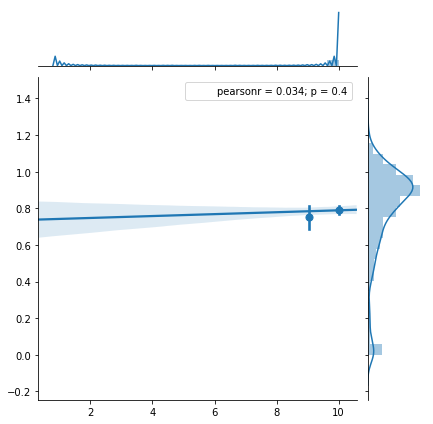

In [55]:
sns.jointplot(np.clip(distances[:,0], 0, 10)[high_volume_venues], shift_base_final.success_rate.values[high_volume_venues], kind='reg', x_bins=10)

ValueError: x and y must be the same size

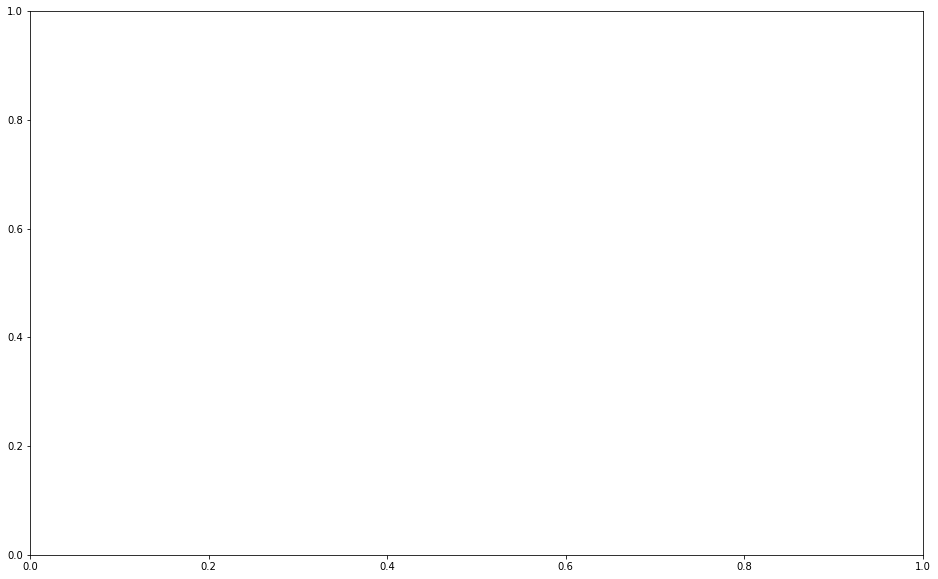

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
plt.scatter(clusts_pop, r2)
plt.xlabel('Number of Clusters')
plt.ylabel('R-Squared')
plt.show()

([array([0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 4.000e+00,
         5.000e+00, 3.000e+00, 7.000e+00, 4.000e+00, 7.000e+00, 4.000e+00,
         5.000e+00, 3.000e+00, 5.000e+00, 3.000e+00, 3.000e+00, 4.000e+00,
         4.000e+00, 5.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 8.000e+00,
         8.000e+00, 2.000e+00, 4.000e+00, 9.000e+00, 3.000e+00, 9.000e+00,
         6.000e+00, 3.000e+00, 9.000e+00, 1.000e+01, 4.000e+00, 4.000e+00,
         1.100e+01, 3.000e+00, 1.000e+01, 8.000e+00, 9.000e+00, 1.000e+00,
         4.000e+00, 3.000e+00, 7.000e+00, 4.000e+00, 4.000e+00, 8.000e+00,
         3.000e+00, 4.000e+00, 4.000e+00, 1.000e+00, 4.000e+00, 2.000e+00,
         4.000e+00, 6.000e+00, 2.000e+00, 7.000e+00, 3.000e+00, 6.000e+00,
         5.000e+00, 9.000e+00, 5.000e+00, 6.000e+00, 1.000e+00, 9.000e+00,
         8.000e+00, 8.000e+00, 8.000e+00, 7.000e+00, 4.000e+00, 8.000e+00,
         3.000e+00, 4.000e+00, 2.000e+00, 1.300e+01, 8.000e+00, 8.000e+00,
         6.000e+00, 5.000

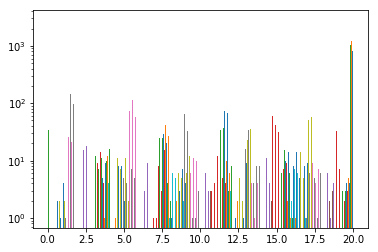

In [57]:
plt.hist(np.clip(distances, 0,20), 100, log=True)

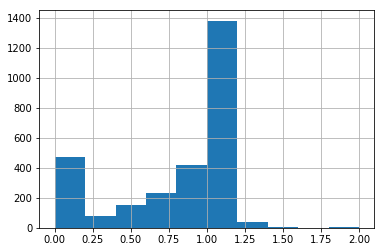

In [58]:
shift_base_final.success_rate.hist()


In [59]:
best_x

array([[-88.08909537,  41.65466659],
       [-87.35146941,  41.90608814],
       [-87.65115806,  41.8676287 ],
       [-87.91018717,  41.9408588 ],
       [-83.5839675 ,  39.8666335 ],
       [-87.42405788,  41.84888698],
       [-85.608017  ,  42.622239  ],
       [-87.637189  ,  41.77135745],
       [-87.77499659,  41.394306  ],
       [-87.42726978,  41.76759944],
       [-87.45223029,  41.90548805],
       [-87.57960105,  41.75276689],
       [-87.74352681,  41.75760134],
       [-87.50499336,  41.65907323],
       [-87.96995832,  42.25812603],
       [-87.26874014,  41.53446857],
       [-87.67444536,  41.97681956],
       [-87.55747681,  41.575469  ],
       [-87.65213899,  41.65951409],
       [-88.2852304 ,  41.96758077],
       [-87.73992388,  41.89256901]])